In [1]:
'''This jupyter notebook generates figure 2 in the paper. The necessary npz file is generated by running the shell script in a slurm environment. '''

import sys 
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt

from matplotlib.backends.backend_pdf import PdfPages

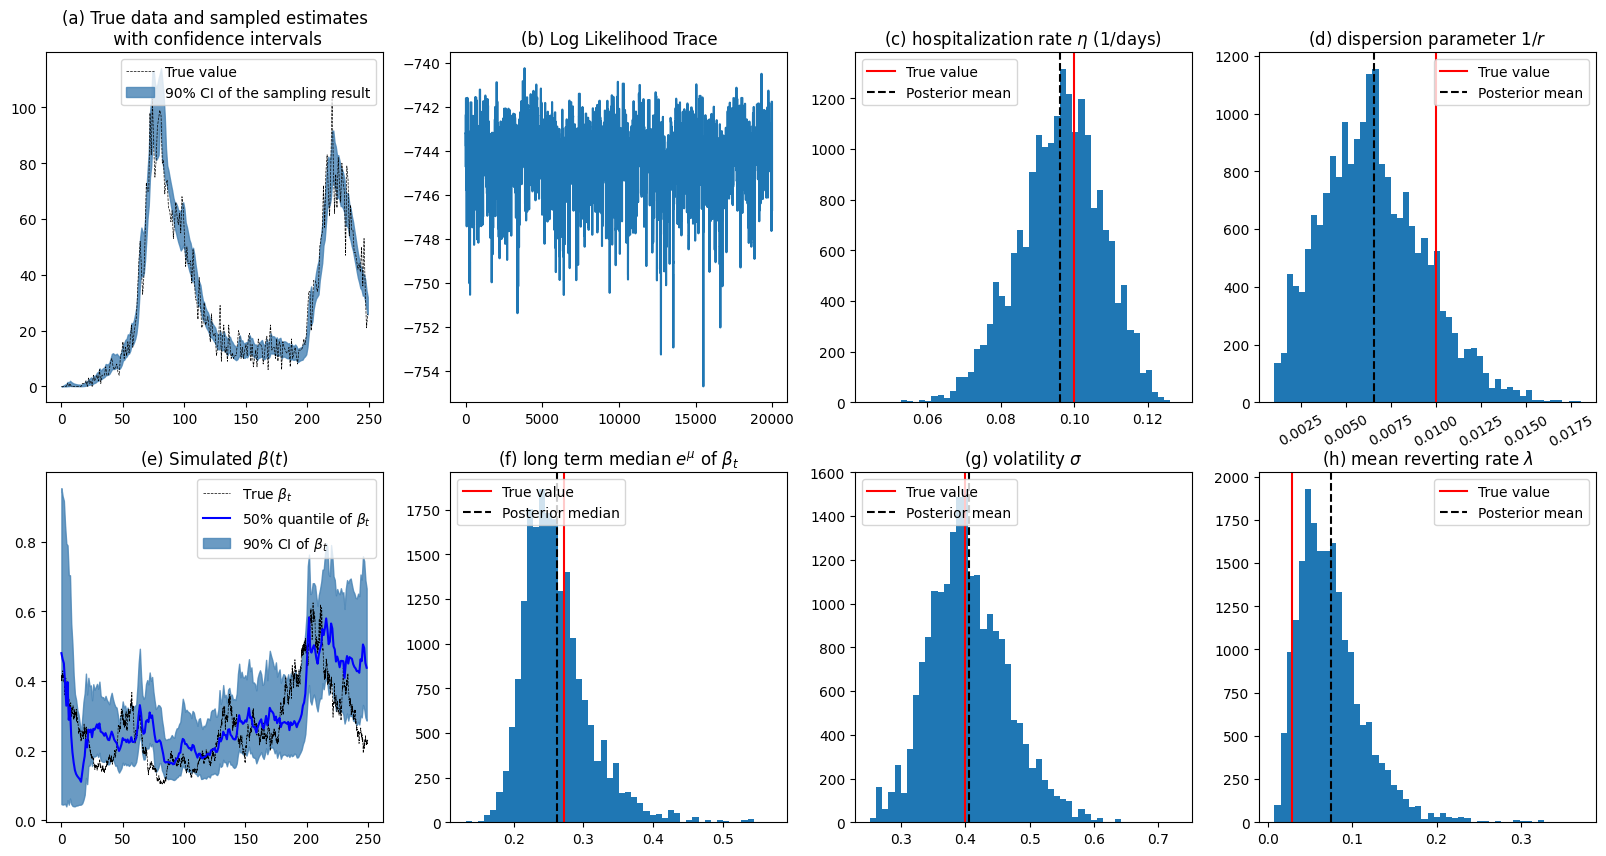

In [5]:
T = 250
dt = 0.1
t_vec = np.arange(0,T,dt)

sig=0.4

'''model params''' 
model_params = {'gamma':1/1000,'L':0.,'D':1/7,'hosp':1/10,'R':1/100,'sig_state':0.005,'lam':1/35,'mean_ou':-1.3,'sig':0.4}

param_names = ['hosp','R','mean_ou','sig','lam']
param_symbol = ['(c) hospitalization rate $\\eta$ (1/days)','(d) dispersion parameter $1/r$','(f) long term median $e^\\mu$ of $\\beta_t$','(g) volatility $\\sigma$','(h) mean reverting rate $\\lambda$']

run=1
burn_in = 80_000
output = np.load(f'Results/PMCMC_Output_exp1_{run}.npz')

#the function extract_intervel(time_series, threshold) retuens the first and last index of the time_series that is greater than the threshold k
extract_intervel = lambda time_series, threshold: (np.argmax(time_series>threshold), len(time_series)-np.argmax(time_series[::-1]>threshold)-1)
k=5

fig,axs = plt.subplots(nrows = 2,ncols = 4,figsize = (20,10))

first,last = extract_intervel(output['data'][0],k)

# Remaining subplots
# Plot for beta_t in axs[1, 3]
#axs[1, 0].fill_between(t_vec[first:last] * (1/dt), 0, np.max(output['MLE_particle_dist'][:, 4, :]), alpha=0.5, color='grey')
mean_beta = np.mean(np.log(output['MLE_particle_dist'][:, 4, :]))
#compute the variance of beta_t in the grey interval
var_beta = np.sqrt(np.var(np.log(output['MLE_particle_dist'][:, 4, :]))/(1-np.exp(-2*sig)))
#compute the std of beta_t in the grey interval
std_beta = np.std(np.log(output['MLE_particle_dist'][:, 4, :]))
#axs[1, 0].plot(t_vec[first:last] * (1/dt), np.ones(last - first) * np.exp(mean_beta), '--', color='black', label='Mean of $\\beta_t$ in \n the grey interval')



# Plotting true data with confidence intervals in axs[0, 0]
axs[0, 0].set_title('(a) True data and sampled estimates\n with confidence intervals')
axs[0, 0].plot(output['data'].T, '--', color='black', lw=0.5, label='True value')
axs[0, 0].fill_between(t_vec[::int(1/dt)],
                       np.percentile(output['MLE_Observation_dist'][:, 0, :].T, 5, axis=1),
                       np.percentile(output['MLE_Observation_dist'][:, 0, :].T, 95, axis=1),
                       alpha=0.8, color='steelblue', label='90% CI of the sampling result')
axs[0, 0].legend(loc = 'upper right')

# Plotting log-likelihood trace in axs[0, 1]
axs[0, 1].set_title('(b) Log Likelihood Trace')
axs[0, 1].plot(output['Log_Likelihood'][burn_in:])

# Plotting parameter estimates in axs[0, 2] and axs[0, 3]
axs[0, 2].hist(output['accepted_params'][0, burn_in:], bins=50)
axs[0, 2].set_title(f"{param_symbol[0]}")
axs[0, 2].axvline(x=model_params[param_names[0]], color='red', label='True value')
axs[0, 2].axvline(x=np.mean(output['accepted_params'][0, burn_in:]), color='black', linestyle='--', label='Posterior mean')
axs[0, 2].legend(loc = 'upper left')

axs[0, 3].hist(output['accepted_params'][1, burn_in:], bins=50)
axs[0, 3].set_title(f"{param_symbol[1]}")
axs[0, 3].axvline(x=model_params[param_names[1]], color='red', label='True value')
axs[0, 3].axvline(x=np.mean(output['accepted_params'][1, burn_in:]), color='black', linestyle='--', label='Posterior mean')
axs[0, 3].legend(loc = 'upper right')

# Rotate xticks for axs[0, 3]
plt.setp(axs[0, 3].xaxis.get_majorticklabels(), rotation=30)

# Plotting simulated beta(t) in axs[1, 0]
axs[1, 0].set_title('(e) Simulated $\\beta(t)$')
axs[1, 0].plot(t_vec, output['betas'], '--', color='black', lw=0.5, label='True $\\beta_t$')
axs[1, 0].plot(t_vec[::int(1/dt)], np.percentile(output['MLE_particle_dist'][:, 4, :].T, 50, axis=1), 
               color='blue', label='50% quantile of $\\beta_t$')
axs[1, 0].fill_between(t_vec[::int(1/dt)],
                       np.percentile(output['MLE_particle_dist'][:, 4, :].T, 5, axis=1),
                       np.percentile(output['MLE_particle_dist'][:, 4, :].T, 95, axis=1),
                       alpha=0.8, color='steelblue', label='90% CI of $\\beta_t$')
#axs[1,0].plot(range(T), np.ones(T) * np.exp(mean_beta), '--', color='red', label='Sample mean of $\\beta(t)$')
axs[1, 0].legend(loc = 'upper right')

# Plotting histogram and vertical lines for beta parameter estimates in axs[1, 1]
axs[1, 1].hist(np.exp(output['accepted_params'][2, burn_in:]), bins=50)
axs[1, 1].axvline(x=np.exp(model_params[param_names[2]]), color='red', label='True value')
axs[1, 1].axvline(x=np.mean(np.exp(output['accepted_params'][2, burn_in:])), color='black', linestyle='--', label='Posterior median')
#axs[1, 1].axvline(x=mean_beta, color='red', linestyle='--',label='Sample mean of $\\beta(t)$')
axs[1, 1].set_title(f"{param_symbol[2]}")
axs[1, 1].legend(loc = 'upper left')


# Plotting in the second row, columns 2 and 3
axs[1, 2].hist(output['accepted_params'][3, burn_in:], bins=50)
axs[1, 2].set_title(f"{param_symbol[3]}")
axs[1, 2].axvline(x=model_params[param_names[3]], color='red', label='True value')
axs[1, 2].axvline(x=np.mean(output['accepted_params'][3, burn_in:]), color='black', linestyle='--', label='Posterior mean')
#axs[1, 2].axvline(x=std_beta, color='orange', linestyle='--',label='sample std of $\\beta(t)$')
axs[1, 2].legend(loc = 'upper left')

axs[1, 3].hist(output['accepted_params'][4, burn_in:], bins=50)
axs[1, 3].set_title(f"{param_symbol[4]}")
axs[1, 3].axvline(x=model_params[param_names[4]], color='red', label='True value')
axs[1, 3].axvline(x=np.mean(output['accepted_params'][4, burn_in:]), color='black', linestyle='--', label='Posterior mean')
axs[1, 3].legend(loc = 'upper right')



# Saving the figure
fig.savefig('figures/fig_full_experiment_good.png', dpi=300)
plt.show()
plt.close(fig)
